In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.optimize import curve_fit
from numpy import exp
from numpy import sin
from numpy import tanh
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from scipy.optimize import differential_evolution

In [2]:
def get_lock_depth_from_params(params):
    a1,a2,b1,b2 = params
    lock_in_depth = [(b1-2)/a1,(b1+2)/a1,(b2-2)/a2,(b2+2)/a2]
    return lock_in_depth

In [3]:
def get_params_from_depths(lock_in_depth):
    l0,l1,l2,l3 = lock_in_depth
    params = [4/(l1-l0),4/(l3-l2),2*(l1+l0)/(l1-l0),2*(l3+l2)/(l3-l2)]
    return params

In [70]:
def e(z):
    '''
    idx = np.where(np.isclose(depth_obs, z))[0]
    idx = idx[0]

    return 1 - fraction_data[idx]
    '''
    return sin(16*z+1.5)/2 + 0.5

In [5]:
def H(z):
    return -tanh(((c2+c1)*(z-(c2+c1)/2))/(c2-c1))

In [6]:
def l (z,s,a1,b1,a2,b2):
    return e(z)/(1+exp(-a1*s+b1)) + (1-e(z))/(1+exp(-a2*s+b2))

In [7]:
def l_diff(z,s,a1,b1,a2,b2):
    return e(z) * (a1*exp(-a1*s+b1))/(1+exp(-a1*s+b1))**2 + (1-e(z)) * (a2*exp(-a2*s+b2))/(1+exp(-a2*s+b2))**2 

In [8]:
def integral(s,z,a1,a2,b1,b2):
    return H(z-s)*l_diff(z,s,a1,b1,a2,b2)

In [9]:
def functional_integration(z, a1, a2, b1, b2):
    # Use quad with scalar z, converting array inputs to floats
    result, _ = quad(lambda s: integral(s, float(z), a1, a2, b1, b2), 0, float(z))
    return result

In [10]:
def get_magnetisation(z, params):
    a1, a2, b1, b2 = params
    
    # Vectorize the integration function to handle array inputs
    vec_func_integration = np.vectorize(functional_integration)
    M = vec_func_integration(z, a1, a2, b1, b2)
    
    return np.tanh(M * 10**3)

In [11]:
def huber_loss(params, z_data, M_obs, delta=1.0):
    # Unpack parameters
    a1, a2, b1, b2 = params
    
    # Compute predicted magnetization
    M_pred = get_magnetisation(z_data, params)
    
    # Compute the residuals
    residuals = M_obs - M_pred
    
    # Compute Huber loss
    loss = np.where(np.abs(residuals) <= delta,
                    0.5 * residuals ** 2,
                    delta * (np.abs(residuals) - 0.5 * delta))
    
    return np.mean(loss)

In [12]:
def random_restarts_optimization(loss_function, initial_guess, bounds, n_restarts=10):
    solutions = []
    for i in range(n_restarts):
        
        # Generate a random initial guess within the bounds
        random_initial = [np.random.uniform(low, high) for low, high in bounds]
        result = minimize(loss_function, random_initial, args=(depth, M_obs), method='L-BFGS-B', bounds=bounds)
        solutions.append(result.x)
        print(f"Iteration: {i+1}")
    return solutions

In [13]:
depth_obs , fraction_data = np.loadtxt('Spassovez.txt', unpack = True)

In [51]:
depth = np.linspace(depth_obs[0],depth_obs[-1],depth_obs.shape[0])

In [52]:
c1 = 5
c2 = 7

In [21]:
params = get_params_from_depths([0.4,1.6,1.7,3.2])

In [53]:
depth = np.linspace(0,10,50)

In [61]:
params1 = [3,2,3,6]

In [82]:
get_lock_depth_from_params(params1)

[0.3333333333333333, 1.6666666666666667, 2.0, 4.0]

In [83]:
get_lock_depth_from_params(params2)

[0.3333333333333333, 1.6666666666666667, 2.1, 4.1]

In [71]:
M_obs1 = get_magnetisation(depth,params1)

In [81]:
params2 = [3,2,3,6.2]

In [75]:
M_obs2 = get_magnetisation(depth,params2)

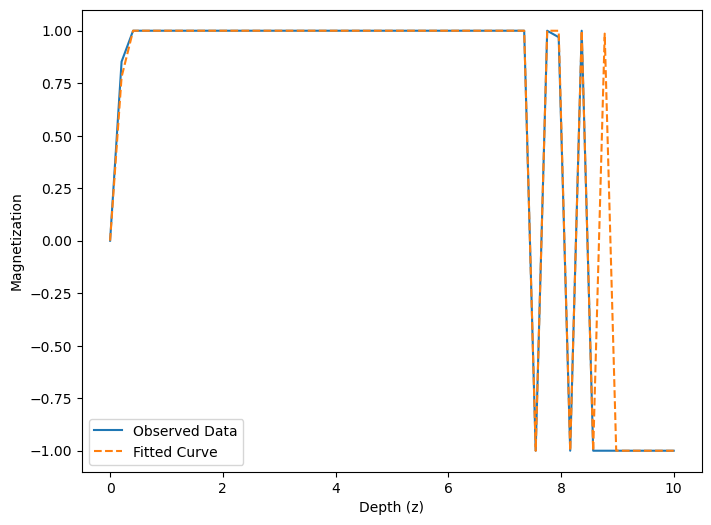

In [80]:
plt.figure(figsize=(8, 6))
plt.plot(depth, M_obs1, label='Observed Data')  # Plot the observed data
plt.plot(depth, M_obs2, label='Fitted Curve',linestyle = 'dashed')  # Plot the fitted curve
plt.xlabel('Depth (z)')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

In [59]:
joint = np.column_stack((depth,e(depth),M_obs))

In [60]:
np.savetxt('data_test_2.txt',joint)

In [19]:
M_obs.shape

(200,)

In [45]:
low = get_params_from_depths([0.1,0.9,1.5,3.])
hight = get_params_from_depths([0.8,2,2,3.5])

In [46]:
np.column_stack((low,hight))

array([[5.        , 3.33333333],
       [2.66666667, 2.66666667],
       [2.5       , 4.66666667],
       [6.        , 7.33333333]])

In [30]:
bounds = [(2., 4.),  # a1
          (0.5, 3.),  # a2
          (0, 3.5),    # b1
          (3., 5.)]    # b2

In [31]:
initial_params = [1.0, 1.0, 1.0, 1.0]

In [36]:
solutions = random_restarts_optimization(huber_loss, initial_params, np.column_stack((low,hight)), n_restarts=10)
print("Multiple solutions found:", solutions)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Multiple solutions found: [array([3.11405055, 2.91308247, 0.85574448, 3.96810593]), array([2.17328994, 0.70522335, 1.94593134, 5.        ]), array([2.60521438, 1.91475102, 2.67501722, 3.28280249]), array([3.21001885, 2.66399854, 3.46398465, 3.45540649]), array([3.83698349, 2.53151311, 1.27037418, 4.52258782]), array([3.61236426, 1.61849949, 3.5       , 5.        ]), array([2.06131109, 2.26231847, 0.54653672, 4.07314004]), array([2.75110844, 0.51201463, 0.17584901, 4.71008238]), array([2.81478073, 2.25041399, 2.40692957, 4.22994404]), array([3.45907253, 0.52417951, 2.94613722, 4.67073479])]


In [44]:
get_lock_depth_from_params(solutions[7])

[0.15403922184666033, 1.6291403973000353, 1.370615497304543, 3.948645762126696]

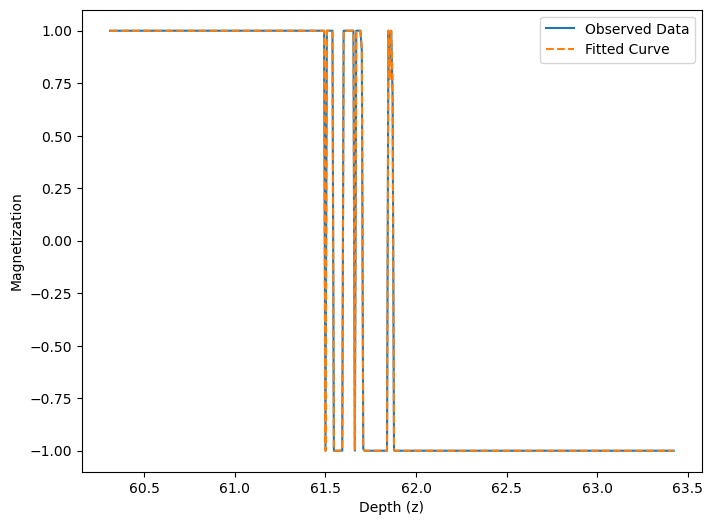

[0.14723921373578114, 1.6432036226707358, 1.5270892614024976, 3.5632082766058275]


In [47]:
ind = 7

M_optimized = get_magnetisation(depth, solutions[ind - 1])

plt.figure(figsize=(8, 6))
plt.plot(depth, M_obs, label='Observed Data')  # Plot the observed data
plt.plot(depth, M_optimized, label='Fitted Curve',linestyle = 'dashed')  # Plot the fitted curve
plt.xlabel('Depth (z)')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

print(get_lock_depth_from_params(solutions[ind - 1]))

In [32]:
result = minimize(huber_loss, initial_params, args=(depth, M_obs), 
                  method='L-BFGS-B', bounds=np.column_stack((low,hight)))

In [33]:
optimized_params = result.x
print('Optimized lock-in-depths:', get_lock_depth_from_params(optimized_params))

Optimized lock-in-depths: [-0.5, 1.5, 1.0, 5.0]


In [34]:
M_optimized = get_magnetisation(depth, optimized_params)

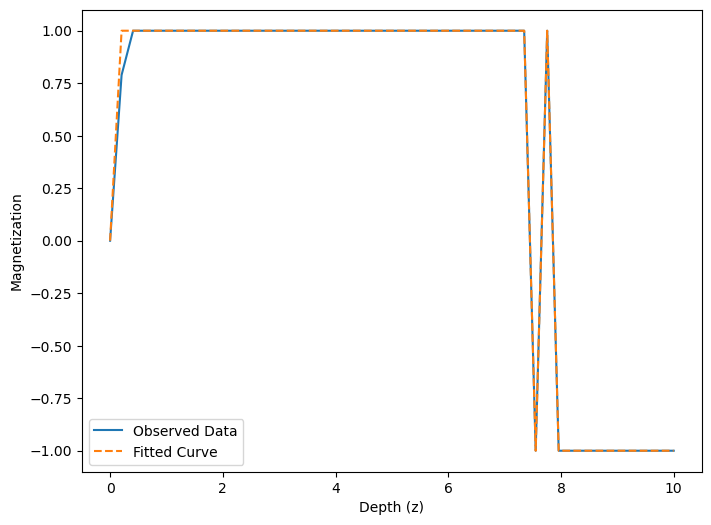

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(depth, M_obs, label='Observed Data')  # Plot the observed data
plt.plot(depth, M_optimized, label='Fitted Curve',linestyle = 'dashed')  # Plot the fitted curve
plt.xlabel('Depth (z)')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

In [90]:
result = minimize(huber_loss, initial_params, args=(depth, M_obs), 
                  method='SLSQP', bounds=bounds)

KeyboardInterrupt: 

In [ ]:
optimized_params = result.x
print('Optimized lock-in-depths:', get_lock_depth_from_params(optimized_params))

In [ ]:
M_optimized = get_magnetisation(depth, optimized_params)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(depth, M_obs, label='Observed Data')  # Plot the observed data
plt.plot(depth, M_optimized, label='Fitted Curve',linestyle = 'dashed')  # Plot the fitted curve
plt.xlabel('Depth (z)')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

In [84]:
result = dual_annealing(huber_loss, bounds, args=(depth, M_obs))

KeyboardInterrupt: 

In [ ]:
optimized_params = result.x
print('Optimized lock-in-depths:', get_lock_depth_from_params(optimized_params))

In [ ]:
M_optimized = get_magnetisation(depth, optimized_params)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(depth, M_obs, label='Observed Data')  # Plot the observed data
plt.plot(depth, M_optimized, label='Fitted Curve',linestyle = 'dashed')  # Plot the fitted curve
plt.xlabel('Depth (z)')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

In [89]:
result = differential_evolution(huber_loss, bounds, args=(depth, M_obs))

KeyboardInterrupt: 

In [ ]:
optimized_params = result.x
print('Optimized lock-in-depths:', get_lock_depth_from_params(optimized_params))

In [ ]:
M_optimized = get_magnetisation(depth, optimized_params)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(depth, M_obs, label='Observed Data')  # Plot the observed data
plt.plot(depth, M_optimized, label='Fitted Curve',linestyle = 'dashed')  # Plot the fitted curve
plt.xlabel('Depth (z)')
plt.ylabel('Magnetization')
plt.legend()
plt.show()